In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# Function to generate allowed basis states under Rydberg blockade for a chain of length L
def generate_allowed_basis(L, pbc=False):
    allowed_states = []
    for i in range(2**L):
        state = format(i, f'0{L}b')
        if '11' not in state and (not pbc or (state[0] != '1' or state[-1] != '1')):
            allowed_states.append(state)
    return allowed_states

# Function to construct the adjacency matrix for the Krylov subspace graph
def construct_krylov_adjacency_matrix(L):
    basis = generate_allowed_basis(L)
    N = len(basis)
    index_map = {state: i for i, state in enumerate(basis)}
    adjacency_matrix = sp.lil_matrix((N, N))

    for state in basis:
        for i in range(L):
            if state[i] == '0':
                new_state = list(state)
                new_state[i] = '1'
                new_state = ''.join(new_state)
                if '11' not in new_state:
                    if new_state in index_map:
                        adjacency_matrix[index_map[state], index_map[new_state]] = 1
                        adjacency_matrix[index_map[new_state], index_map[state]] = 1

    return adjacency_matrix, basis

# Function to compute entanglement entropy for a given eigenstate
def compute_entanglement_entropy(eigenstate, L, cut_position=None):
    if cut_position is None:
        cut_position = L // 2
    
    half_dim = 2**cut_position
    rho_A = np.zeros((half_dim, half_dim), dtype=complex)
    
    for i in range(len(eigenstate)):
        bitstring = format(i, f'0{L}b')
        left_part = bitstring[:cut_position]
        right_part = bitstring[cut_position:]
        
        left_idx = int(left_part, 2)
        right_idx = int(right_part, 2)
        
        rho_A[left_idx, left_idx] += np.abs(eigenstate[i])**2

    rho_A = rho_A / np.trace(rho_A)
    eigenvalues = np.linalg.eigvalsh(rho_A)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    entropy = -np.sum(eigenvalues * np.log(eigenvalues))
    
    return entropy

# Function to compute entanglement entropy for all eigenstates of the PXP Hamiltonian
def analyze_entanglement_entropy(L):
    adjacency_matrix, basis = construct_krylov_adjacency_matrix(L)
    H_pxp = adjacency_matrix.tocsc()
    eigenvalues, eigenvectors = spla.eigsh(H_pxp, k=len(basis) - 1, which='SA')

    entropies = [compute_entanglement_entropy(eigenvectors[:, i], L) for i in range(len(basis) - 1)]

    df_entropy = pd.DataFrame({
        'Eigenvalue': eigenvalues,
        'Entanglement Entropy': entropies
    })

    return df_entropy

In [9]:
# Compute entanglement entropy for L=3 - debugging

L=3

print(len(generate_allowed_basis(L, pbc=True)))
print(generate_allowed_basis(L, pbc=True))
print(len(generate_allowed_basis(L, pbc=False)))
print(generate_allowed_basis(L, pbc=False))

df_entropy_results = analyze_entanglement_entropy(L)

4
['000', '001', '010', '100']
5
['000', '001', '010', '100', '101']


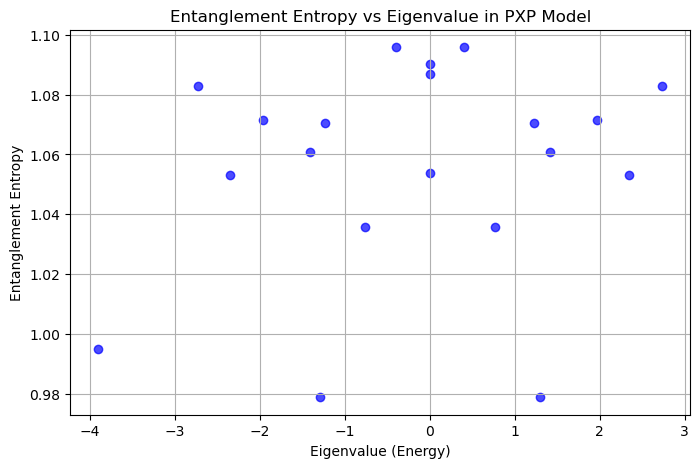

In [4]:
# Plot entanglement entropy vs eigenvalue
plt.figure(figsize=(8, 5))
plt.scatter(df_entropy_results['Eigenvalue'], df_entropy_results['Entanglement Entropy'], color='blue', alpha=0.7)
plt.xlabel('Eigenvalue (Energy)')
plt.ylabel('Entanglement Entropy')
plt.title('Entanglement Entropy vs Eigenvalue in PXP Model')
plt.grid(True)
plt.show()